In [1]:
import numpy as np

##my stuff
from imagery_psychophysics.src.stirling_maps import sparse_point_maps as spm
from imagery_psychophysics.src.model_z import noise_grid
from mpl_toolkits.axes_grid1 import ImageGrid

##other stuff
from matplotlib.colors import LinearSegmentedColormap
from scipy.misc import comb as nCk
from time import time
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function, shared
from theano.tensor.extra_ops import repeat, to_one_hot
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from matplotlib.mlab import griddata
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


# In which we 
* contend with the fact that an extremely noisy subject could possibly guess 0.
* introduce a %correct metric

### Theano expressions

In [2]:
floatX = 'float32'

#### Generate samples of object maps from a posterior over object maps

In [3]:
##the variational posterior over object maps Z
_Q_Z = T.matrix('Q_Z')            ##(K,D)
_M = T.scalar('M',dtype='int32')

##a theano random number generator
rng = MRG_RandomStreams(use_cuda = True)

##sample one Z map from posterior Q_Z
_Z_samples = rng.multinomial(pvals = repeat(_Q_Z.T,_M,axis=0)).reshape((_Q_Z.shape[1],_M,_Q_Z.shape[0])).dimshuffle((1,2,0))

#### Object count probabilities (was previously calling this "object responsibility" because I vaguely remembered this type of jargon from studying EM).

In [4]:
##block of sampled object maps
_Z = T.tensor3('Z') ##(M x K x D)

##window index indicator (N X D)
_W = T.matrix('windows')


An expression for an (M,N) matrix of objects counts. Each row provides the object count in each window for one of the M object map samples in Z.

In [5]:
##(M x K x 1 x D)
##         N x D
##(M x K x N x D)  sum(D)
##(M x K x N)      clip(0,1)
##(M x K x N)      sum(K)
##(M x N)
_object_counts = T.sum(_Z.dimshuffle((0,1,'x',2))*_W,axis=-1).clip(0,1).sum(axis=1)

Now apply one-hot-encoding and sum across samples and divide to obtain object count probabilities 

In [6]:
##number of objects theano variable
_K = T.scalar('objects',dtype='int32')

##non-normalized object count probs
_object_count_prob_nn = to_one_hot(_object_counts.astype('int32').flatten()-1,_K).reshape((_object_counts.shape[0],_object_counts.shape[1],_K)).sum(axis=0)

##object count probs (N x K)
_object_count_prob = _object_count_prob_nn / _object_count_prob_nn.sum(axis=1).reshape((_object_count_prob_nn.shape[0], 1))

#### Update variational posterior for one pixel

This will be the only update that returns a normalized variational posterior.
Uses the object_count_prob matrix above.  
Uses a place-holder for log-loglihood (lnP_star)

In [7]:
##K x N x K tensor of object count probs
##the first K is object id, the last K is object count
_oc_probs = T.tensor3('oc_probs') 

##N x K, this will just be the log of P_star. 
_lnP_star = T.matrix('lnP_star')

## K x 1, this is place holder for the dot product between pixel value and expected log of hyperparameters pi
_v = T.matrix('prior_penalties')

      ##K x N x K oc_probs
##(tensordot)
          ##N x K lnP_star 
      ##K x 1     lnQ_z
##(add V)
      ##K x 1
##(exp)
      ##K x 1     Q_z_nn
##(normalize)
      ##K x 1     Q_z, the variational posterior element for one pixel

##log of Q_z (minus unknown constant that normalizes things)    
_lnQ_z = T.tensordot(_oc_probs, _lnP_star, [[1,2], [0,1]]).dimshuffle([0,'x'])+_v

##non-normalized Q_z. we shift by max value to stabilize upcoming exp
_Q_z_nn = T.exp(_lnQ_z-T.max(_lnQ_z)) 

##variational posterior prob for one pixel
_Q_z = _Q_z_nn / _Q_z_nn.sum()

#### Update rule for the variational log posterior over theta (i.e., the noise parameters).
We calculate $ln[q(\theta)] - const$  
We use max of the above for calculating the ELBO.  
We use argmax of the above for updating the variational posteriors


In [8]:
_P_theta = T.tensor3('P_theta') ##(G x N x K)
_X = T.matrix('oc_prob_dummy') ##N x K ~ this is a place holder for the "object count prob" matrix
_lkhd_param_grid = T.matrix('lkhd_param_grid') ## G x 2 grid of candidate noise parameters. we must supply.

##(G x N x K)
##(    N x K)  (dot product, broadcast across G)
##(G x 1)  --> because we don't do vectors we reshape to make output 2Dimensional (G x 1)

##log of likelihood

_ln_P_theta = T.log(_P_theta)

##ln q(theta+, theta-) - const (G x 1)
_lnQ_theta = T.tensordot(_ln_P_theta, _X, axes=[[1,2], [0,1]],).reshape((_P_theta.shape[0], 1))

##---for max approximation

##find index of the best lkhd params (scalar integer)
_theta_star_idx = T.argmax(_lnQ_theta)
# _G = _lkhd_param_grid.shape[0]
# _theta_star_idx = T.argsort(_lnQ_theta)[T.iround(_G/2.)]

#N x K (windows x object counts)
_P_star = _P_theta[_theta_star_idx,:,:]

#1 x 2 best likelihood params
_theta_star = _lkhd_param_grid[_theta_star_idx,:]

##---for full bayesian treatment
_lnQ_theta_star = T.max(_lnQ_theta)
_Q_theta_nn = T.exp(_lnQ_theta - _lnQ_theta_star)
_Q_theta = _Q_theta_nn / _Q_theta_nn.sum()

#### Prior over object maps
The hyperparameter $\pi$ is prior over object sizes. It is Dirichlet distributed.  
We need $\mathbb{E}[ln[\pi]]$ to update Q_z. We'll also need it to calculate the ELBO.

In [9]:
_alpha_0 = T.scalar('alpha_0')
_q_Z = T.matrix('q_Z')  ##K x 1, this is result of summing over pixels in Q_Z matrix. very different from Q_z

_alpha = _q_Z + _alpha_0 ##broadcasts the scalar _alpha_0 across K

##(K x 1) this is needed to update Q_z
_Eln_pi = T.psi(_alpha) - T.psi(_alpha.sum())

##(K x 1) not needed for update of variational posteriors, but we'll want it for model interpretation
_E_pi = _alpha / _alpha.sum()

#### Expressions for the ELBO
This is an approximate ELBO because:  
1. We are using a $ln[q(\theta^*)]$ instead of $\mathbb{E}[ln[q(\theta)]]$, where $\theta^* = \underset{\theta}{\operatorname{argmax}}  q(\theta)$.
2. We approximate object count probabilities by sampling $M$ object maps from $Q_Z$ and computing a histogram

In [10]:
_lnQ_theta_star = T.scalar('lnQ_theta_star') ##scalar

_Q_Z_holder = T.matrix('Q_Z_holder') ##N x K 

##scalar: the entropy of the variational posterior
a_min = 10e-15
a_max = 1
_posterior_entropy = -T.tensordot(_Q_Z_holder.clip(a_min,a_max), T.log(_Q_Z_holder.clip(a_min,a_max)))

##scalar
_badness_of_fit = -_lnQ_theta_star

##scalar
_ELBO = -_badness_of_fit  + _posterior_entropy

#### Expressions for predictive distribution

In [11]:
_P_star_pred = T.matrix('lkhd_table_pred') ##K x K ~ responses x counts


##windows x 1         x counts  |
##          responses x counts    tensordot
##windows x responses

_pred_dist = T.tensordot(_object_count_prob, _P_star_pred, axes = [[1],[1]])



### Theano functions

#### Generate M samples of object maps from a variational posterior over all pixels, Q_Z

In [12]:
##returns M x K x D (samples x object ids x pixels)
Z_sample_func = function([_Q_Z,_M],outputs=_Z_samples)

#### Estimate object count probabilities from a stack of object map samples Z (given windows W)

In [13]:
##returns N x K (windows x object counts)
object_count_prob_func = function([_Z, _W, _K], outputs = _object_count_prob)

#### Update variational posterior for one pixel

In [14]:
##returns K x 1 (objects ids x 1)
Q_z_update_func = function([_oc_probs, _lnP_star, _v], outputs = _Q_z)

#### Update likelihood parameters (returns $\Theta^*$, $P^*$, and $q(\theta_+, \theta_-)$)

In [15]:
##returns theta_star ~ (1 x 2) best lkhd params
##returns P_star (N x K) (windows x object counts)
##return lnQ_theta G x 1
lkhd_update_func = function([_P_theta, _X, _lkhd_param_grid], outputs = [_theta_star, _P_star, _lnQ_theta, _Q_theta])

#### Update $\mathbb{E}[ln[\pi]]$ and $\mathbb{E}[\pi]$

In [16]:
##returns _Eln_pi (K x 1) (object ids x 1)
##returns _E_pi (K x 1) (object ids x 1)
prior_update_func = function([_q_Z, _alpha_0], outputs = [_Eln_pi, _E_pi])

#### Calculate the ELBO

In [17]:
## returns three scalar values. ELBO is last
ELBO_update_func = function([_Q_Z_holder, _lnQ_theta_star], outputs=[_badness_of_fit, _posterior_entropy, _ELBO])

#### Construct predictive distribution

In [18]:

pred_dist_func = function([_P_star_pred, _Z, _W, _K], outputs = _pred_dist)

### The likelihood function
A note on jargon/notation: p_on, p_off = theta_+, theta_- = likelihood parameters = noise parameters

In [19]:
##helper
def counts(r,c,K):
    return np.array([nCk(c,m)*nCk(K-c, r-m) for m in range(min(r,c)+1)])

##the strange likelihood I derived for this model
#
def lkhd(r,c,K,p_on,p_off):
    probs = np.array([(1-p_on)**(c-m) * (p_on)**m * (p_off)**(r-m) * (1-p_off)**(K-c-r+m) for m in range(min(r,c)+1)])
    #print probs
    return counts(r,c,K).dot(probs)

##create a stack of data likelihood tables for different values of the noise params 
def lkhd_grid(observed_responses, theta_dns, K):
    '''
    returns
    P_theta ~ G x N x K
    lkhd_param_grid ~ G x 2
    '''
    p_on, p_off = noise_grid(theta_dns,theta_dns)
    N = observed_responses.shape[0]  ##number of windows
    G = len(p_on) ##number of values of parameters to evaluate
    P_theta = np.zeros((G, N, K),dtype=floatX)
    lkhd_param_grid = np.zeros((G,2),dtype=floatX)
    for g,p in enumerate(zip(p_on,p_off)):
        lkhd_param_grid[g,0] = p[0]   ##let's make sure we get all indices in the same order
        lkhd_param_grid[g,1] = p[1]
        for n in range(N):
            for k in range(K):
                P_theta[g,n,k]  = lkhd(observed_responses[n].squeeze(),k+1,K, p[0],p[1])
    return P_theta, lkhd_param_grid

### Machinery for sampling-based likelihood maximization

In [20]:
##for generating stacks of one-hot-encoded object maps
def make_object_map_stack(K, num_rows, num_cols, size_of_field,num_maps):
    object_map_base = spm(num_rows,num_cols,size_of_field,cluster_pref = 'random',number_of_clusters = K)
    object_maps = np.zeros((num_maps, K, size_of_field**2))
    for nm in range(num_maps):
        object_map_base.scatter()
        tmp = np.squeeze(object_map_base.nn_interpolation())
        ##convert to one_hot encoding
        tmp = np.eye(K)[tmp.ravel()-1].T  ##K x D
        object_maps[nm] = tmp
    return object_maps

In [21]:
##function for generating object counts
##get true object counts for each window
def get_object_counts(object_maps, windows):
    '''
    object_maps   =  M x K x D      newaxis
                     M x K x 1 x D
        windows   =          N x D  mult
                     M x K x N x D  sum(axis=-1)
                     M x K x N      clip(0,1).sum(axis=1)
    object_counts =  M x   x N      astype(int)
    
    '''
    return np.sum(object_maps[:, :,np.newaxis,:]*windows,axis=-1).clip(0,1).sum(axis=1).astype('int')


In [22]:
def get_noisy_object_counts(object_maps, windows, p_on, p_off):
    '''
    object_maps   =  M x K x D
        windows   =      N x D  
    
    returns
     noisy_object_counts  = M x N
    '''
    
    K = object_maps.shape[1]
    object_counts = get_object_counts(object_maps, windows) ##M x N
    M = object_counts.shape[0]
    N = object_counts.shape[1]
    observed_responses = np.zeros((M,N), dtype = 'int')
    for m in range(M):
        for n in range(N):
            resp_dist = np.zeros(K+1)
            oc = object_counts[m,n]
            for k in range(K+1):
                resp_dist[k] = lkhd(k,oc,K,p_on,p_off)
            observed_responses[m,n]=np.argmax(np.random.multinomial(1,resp_dist))
    return observed_responses

In [23]:
def my_to_one_hot(count_tensor, K):
    '''
    count_tensor  = M x N
    returns M x N x K
    '''
    M = count_tensor.shape[0]
    N = count_tensor.shape[1]
    one_hot_count_tensor = np.zeros((M, N, K))
    id_mat = np.eye(K)
    for m in range(M):
        one_hot_count_tensor[m,:, :] = id_mat[count_tensor[m]-1]
    return one_hot_count_tensor

In [24]:
##given some response, evaluate likelihoods of many object maps
def evaluate_log_likelihoods(observed_responses, object_map_stack, windows, p_on, p_off, lkhd_table=None):
    '''
    observed_responses  = 1 x N
    object_map_stack = M x K x D
    windows = N x D
    
    returns log_lkhds = M x 1
    '''
    N = observed_responses.shape[1]
    K = object_map_stack.shape[1]
    M = object_map_stack.shape[0]

    ##reshape observed_responses for convenience
    observed_responses = observed_responses.reshape((N,))
    ##create a likelihood table (N x K)
    if lkhd_table is None:
        lkhd_table = np.zeros((N,K), dtype=floatX)
        for n in range(N):
            for k in range(K):
                lkhd_table[n,k]  = np.log(lkhd(observed_responses[n],k+1,K, p_on,p_off))
            
    ##get object_counts ( M x N)
    object_counts = get_object_counts(object_map_stack, windows)
    
    ##one-hot encoding of object counts M x N x K
    one_hot_object_counts = my_to_one_hot(object_counts, K)
    
    
    ##evaluate log_likelihoods
    ## one_hot_object_counts = M x N x K
    ##            lkhd_table =     N x K tensordot
    ## log_lkhds = M x 1
    return np.tensordot(one_hot_object_counts, lkhd_table, axes=2)
    
    

### Machinery for evaluating predictive distribution on test data

In [25]:
def create_lkhd_table(K, theta_plus, theta_minus):
    lkhd_table = np.zeros((K+1,K), dtype=floatX)
    for r in range(K+1):
        for c in range(K):
            lkhd_table[r,c] = lkhd(r,c+1, K, theta_plus, theta_minus)
    return lkhd_table
            

In [26]:
def eval_log_pred_dist(Q_Z, M, test_responses, test_windows, theta_plus, theta_minus, lkhd_table = None):
    '''
    Q_Z ~ K x D
    M  ~ number of samples
    test_responses ~ 1 x N
    test_windows ~ N x D
    theta_plus, theta_minus ignored if lkhd_table is provided
    lkhd_table ~ K+1 x K  = responses x counts(created if not provided)
    returns
        log_eval_PD
    '''
    N = test_responses.shape[1]
    resp_dx_list = (test_responses).ravel().astype('int').tolist()
    K = Q_Z.shape[0]
    if lkhd_table is None:
        lkhd_table = create_lkhd_table(K, theta_plus, theta_minus)
    Z_samples = Z_sample_func(Q_Z, M).astype(floatX)
    PD = pred_dist_func(lkhd_table, Z_samples, test_windows, K)
    eval_PD = PD[range(N), resp_dx_list]
    log_eval_PD = np.log(eval_PD)
    return log_eval_PD

In [27]:
def percent_correct(Q_Z, M, test_responses, test_windows, theta_plus, theta_minus, lkhd_table = None):
    N = test_responses.shape[1]
    K = Q_Z.shape[0]
    if lkhd_table is None:
        lkhd_table = create_lkhd_table(K, theta_plus, theta_minus)
    Z_samples = Z_sample_func(Q_Z, M).astype(floatX)
    PD = pred_dist_func(lkhd_table, Z_samples, test_windows, K)
    predictions = np.argmax(PD, axis=1)
    fraction_correct = np.sum(test_responses==predictions) / (N*1.)
    return fraction_correct*100, predictions
    

In [28]:
np.sum(np.array([1,2,3])==np.array([1,1,3]))

2

### Simulated data
Generate windows W (N x D), target object map test_Z (K x D), and simulated responses observed_responses (N x 1)

In [29]:
sqrt_D = 8
D = int(sqrt_D*sqrt_D)#number of pixels
K = 6#number of objects


p_on = 0.76
p_off = 0.1

#### Design windows. These are square windows and pairs of square windows of various sizes.

In [30]:
##construct windows W ~ (N x D)
scales = np.array([1])
stride = 1
sizes = [1] #scales/2
Windows = []
for sz in sizes:
    scale_count = 0
    for rows in np.arange(sz,sqrt_D,stride,dtype=int, ):
        for cols in np.arange(sz,sqrt_D,stride,dtype=int):
            one_win = np.zeros((sqrt_D,sqrt_D),dtype=floatX)
            one_win[(rows-sz):(rows+sz), (cols-sz):(cols+sz)]=1
            Windows.append(one_win)
            scale_count +=1
    print scale_count


N = len(Windows)
n_groups = 7*D 
group_order = 6
W = np.zeros((N+n_groups,D),dtype=floatX)
for n in range(N):
    W[n,:] = Windows.pop().ravel()

for n in range(N,N+n_groups):
    rand_pairs = np.random.permutation(N)[:group_order]
    W[n,:] = np.clip(np.sum(W[rand_pairs[0:group_order],:],axis=0), 0, 1)

W = W[:(N+n_groups),:]
    
    
N = W.shape[0]
print N

49
497


#### Construct a target object map

In [31]:
test_object_map = make_object_map_stack(K,4,4,sqrt_D,1)

#### Generate simulated responses

In [32]:
##generate some fake responses using fixed theta parameters
observed_responses = get_noisy_object_counts(test_object_map, W, p_on, p_off)

test_responses = get_noisy_object_counts(test_object_map, W, p_on, p_off)


In [33]:
observed_responses.max()

6

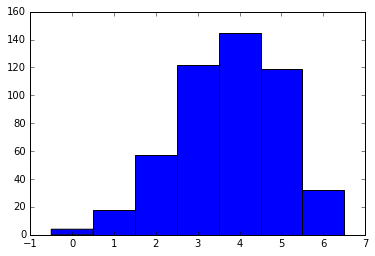

In [34]:
_=plt.hist(observed_responses.T, bins = range(K+2), align = 'left', range = [0, K], )

### CAVI loop

#### Initialization functions

In [35]:
def init_Q_Z(observed_responses, windows, num_maps, theta_plus, theta_minus, dirichlet_param, K, D):
    sqrt_D = int(np.sqrt(D))
    map_stack = make_object_map_stack(K, 2*K, 2*K, sqrt_D,num_maps)
    starter_logs = evaluate_log_likelihoods(observed_responses, map_stack, windows, theta_plus, theta_minus)
    best_start_map = np.argmax(starter_logs)
    start_Z = map_stack[best_start_map] ## K x D
    best_start_map_image=see_Z_sample(start_Z, sqrt_D, show=False)
    Q_Z = np.zeros((K,D), dtype=floatX)
    for d in range(D): #np.random.permutation(D):
        Q_Z[:,d] = np.random.dirichlet(start_Z[:,d]+dirichlet_param)
    return Q_Z, best_start_map_image, starter_logs

In [36]:
def init_Eln_pi(Q_Z, dirichlet_param):
    q_Z = Q_Z.sum(axis=1, keepdims=True) ##a fake q_Z, should be K x 1
    Eln_pi, _ = prior_update_func(q_Z, dirichlet_param)
    return Eln_pi

In [37]:
def init_P_star(observed_responses, theta_plus, theta_minus, K):
    N = observed_responses.shape[1]
    observed_responses = np.squeeze(observed_responses)
    P_star = np.zeros((N,K),dtype=floatX)
    for n in range(N):
        for k in range(K):
            P_star[n,k]  = lkhd(observed_responses[n],k+1,K, theta_plus,theta_minus)
    return P_star

#### Visualization functions

In [38]:
##visualize the variational posterior over pixels
def see_Q_Z(Q_Z, target_object_map = None, clim=[0,1]):
    ##view: construct an image grid
    fig = plt.figure(1, (30,10))
    K = Q_Z.shape[0]
    if target_object_map is not None:
        K += 1
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    if target_object_map is not None:
        im = grid[0].imshow(target_object_map,cmap='Dark2')
        grid[0].cax.colorbar(im)
        for kk in range(1,K):
            im = grid[kk].imshow(Q_Z[kk-1], cmap='hot', clim=clim)
            grid[kk].cax.colorbar(im)

    else: 
        for kk in range(0,K):
            im = grid[kk].imshow(Q_Z[kk], cmap='hot', clim=clim)
            grid[kk].cax.colorbar(im)

In [39]:
##this will help visualize samples from Q_Z
def see_Z_sample(Z,sqrt_D,axis=0,show=True):
    '''
    Z ~ K x D
    convert to 1 x D, D[i] = j, j = argmax(Z[:,i])
    '''
    Z_image = np.argmax(Z,axis=axis).reshape(sqrt_D,sqrt_D)
    if show:
        ax = plt.pcolor(Z_image,cmap='Dark2')
        plt.axes().set_aspect('equal', 'datalim')
    return Z_image


In [40]:
##visualize Q_theta (or lnQ_theta)
def see_Q_theta(Q_theta, lkhd_param_grid):
    ##name the data
    x = lkhd_param_grid[:,0]
    y = lkhd_param_grid[:,1]
    z = Q_theta.squeeze()
    
    # define grid.
    
    xi = np.linspace(-0.01, 1.01, 300)
    yi = np.linspace(-0.01, 1.01, 300)
    # grid the data.
    zi = griddata(x, y, z, xi, yi, interp='linear')
    # contour the gridded data, plotting dots at the nonuniform data points.
    CS = plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
    CS = plt.contourf(xi, yi, zi, 15,
    vmax=abs(zi).max(), vmin=-abs(zi).max())
    plt.colorbar()  # draw colorbar
    # plot data points.
    plt.scatter(x, y, marker='o', s=5, zorder=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    

In [41]:
##object confusion matrix, sort of
##for each object, calculate the log-prob under the variational posterior for each class. return. display
def object_confusion(Q_Z, Z, show=False):
    '''
    log_prob_kj = (K x K) log-prob of class k in Q_Z given object j in object map Z
    '''
    K = Z.shape[0]
    log_prob = np.zeros((K,K))
    for k in range(K):
        for j in range(K):
            log_prob[k,j] = np.sum(np.log(Q_Z[k].clip(10e-15,1))*Z[j])
    
    if show:
        plt.pcolor(log_prob, cmap='gray')
        plt.axes().set_aspect('equal', 'datalim')
        plt.colorbar()
    return log_prob

def see_posterior_overlay(Q_Z, Z):
    '''
    Q_Z ~ K x D
      Z ~ K x D
    '''
    ##view: construct an image grid
    fig = plt.figure(1, (40,20))
    K = Q_Z.shape[0]
    sqrt_D = int(np.sqrt(Q_Z.shape[1]))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    
    colors = [(0, 0, 0), (1., 1., 0)]
    cm_1 = LinearSegmentedColormap.from_list(
        'object_map', colors, N=2)

    colors = [(0, 0, 0), (0., 0., 1.)]
    cm_2 = LinearSegmentedColormap.from_list(
        'prob', colors, N=20)

    
    log_prob = object_confusion(Q_Z, Z)
    Q_Z = Q_Z.reshape((K, sqrt_D, sqrt_D))
    Z = Z.reshape((K, sqrt_D, sqrt_D))
    for k in range(K):
        
        max_k,max_j = np.unravel_index(np.argmax(log_prob), log_prob.shape)
        log_prob[max_k,:] = -np.inf
        log_prob[:,max_j] = -np.inf
        grid[k].imshow(Z[max_j],cmap=cm_1)
        grid[k].imshow(Q_Z[max_k], cmap=cm_2, clim=[0,1], alpha = 0.6)
        
    
    
    
            

#### View target

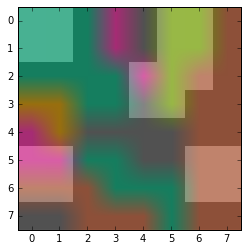

In [42]:
test_object_map_image = see_Z_sample(test_object_map[0], sqrt_D, show=False)
plt.imshow(test_object_map_image, cmap='Dark2')
plt.imshow(W[-5].reshape((sqrt_D,sqrt_D)).astype('uint8')*255, interpolation='none', alpha = .2, cmap=plt.cm.gray, clim=[0,255])

#### Set params and initialize

In [43]:
##initial randomness: controls randomness of each pixel's Q_z
alpha_0 = .8

##initial guess noise params
theta_plus, theta_minus = .99, .01

##density of sampling grid of lkhd params
theta_dns = 25

##number of randomly generated maps to evaluate for initial condition of Q_Z
num_starter_maps = 5000

##number of samples from Q_Z per update
M = 10#number of object map samples to generate for calculating object responsibility

##number of iterations before quitting
max_t = 50

##Q_Z = K x D
Q_Z, best_start_map_image, starter_logs = init_Q_Z(observed_responses, W, num_starter_maps, theta_plus, theta_minus, alpha_0, K, D)
best_Q_Z = Q_Z.copy()

##N x K
P_star = init_P_star(observed_responses, theta_plus, theta_minus, K)

##K x 1
Eln_pi = init_Eln_pi(Q_Z, alpha_0)

In [44]:
##G x N x K
# P_theta = P_star[np.newaxis,:,:]
# lkhd_param_grid = np.array([theta_plus, theta_minus], dtype=floatX, ndmin=2)
P_theta, lkhd_param_grid = lkhd_grid(observed_responses[0], theta_dns, K)
lkhd_param_grid = lkhd_param_grid.astype(floatX)

/musc.repo/Docs/tnaselar/code/Python/imagery_psychophysics/src/model_z.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  p_on =  [np.array([ii]*np.max([np.ceil(D*ii),1])) for ii in np.linspace(small,1-small,dns)]


In [45]:
##get an initial lnQ_theta_star so we can calculate an initial ELBO
##update lkhd params
Z = Z_sample_func(Q_Z, M).astype(floatX)
oc_probs = object_count_prob_func(Z, W, K)
theta_star, P_star, lnQ_theta, Q_theta= lkhd_update_func(P_theta, oc_probs, lkhd_param_grid.astype(floatX))

##calculate starter ELBO
ELBO_history = np.zeros((max_t+1,1))
badness_of_fit, posterior_entropy, ELBO_history[0] = ELBO_update_func(Q_Z, lnQ_theta.max())

##calcualte starter pred. dist\
ln_PD = np.zeros((max_t+1,1))
ln_PD[0] = eval_log_pred_dist(Q_Z, M, test_responses, W, theta_plus, theta_minus).mean()
best_ln_PD = ln_PD[0]

##calculate starter performance
prc_correct = np.zeros((max_t+1,1))
prc_correct[0], preds = percent_correct(Q_Z, M, test_responses, W, theta_plus, theta_minus)
best_prc_correct = prc_correct[0]

print '===========ELBO: %f' %(ELBO_history[0])
print 'badness of fit: %f' %(badness_of_fit)
print 'posterior_entropy: %f' %(posterior_entropy)
print '\n'

print 'mean log of predictive distribution over test samples: %f' %(ln_PD[0])
print '\n'

print 'pecent correct over test samples: %f' %(prc_correct[0])
print '\n'



delta_ELBO = np.inf

min_delta_ELBO = 10e-10
ELBO_old = 0.

===========ELBO: -675.126648
badness of fit: 763.773193
posterior_entropy: 88.646553


mean log of predictive distribution over test samples: -5.689271


pecent correct over test samples: 8.853119




In [46]:
# test_responses
preds

array([3, 3, 3, 3, 3, 2, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6,

#### View starting point and target

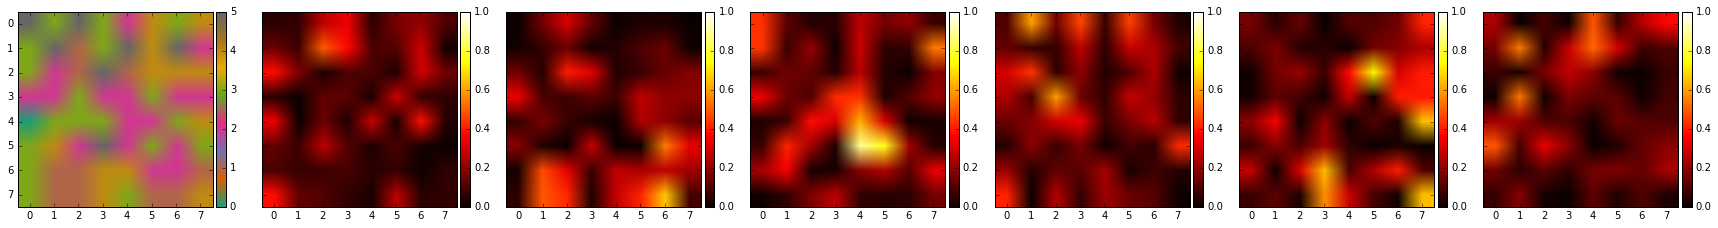

In [47]:
see_Q_Z(Q_Z.reshape((K,sqrt_D,sqrt_D)), target_object_map=best_start_map_image)

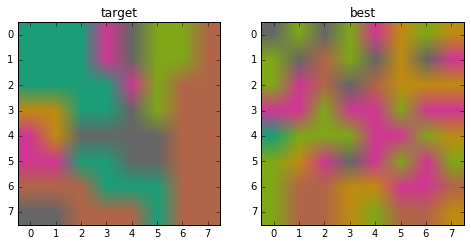

In [48]:
fig = plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.imshow(best_start_map_image, cmap='Dark2')
plt.title('best')

plt.subplot(1,2,1)
plt.imshow(test_object_map_image, cmap='Dark2')
plt.title('target')

#### Evaluate predictive distribution

#### Main loop


In [49]:
##other scalars
t = 1




while (delta_ELBO > min_delta_ELBO) and (t <= max_t):
    
    
    ##put lkhd in log domain
    lnP_star = np.log(P_star).astype(floatX)
    
    ##coordinate ascent on variational posteriors of object map pixels
    for d in range(D):
        Z = Z_sample_func(Q_Z, M).astype(floatX)  ##M x K x D
        oc_probs = np.zeros((K, N, K),dtype=floatX)
        v = np.zeros((K,1), dtype=floatX)
        for k in range(K): 
            Z[:,:,d] = 0.    ##clear out object assignment for pixel d
            Z[:,k, d] = 1.   ##assign pixel d to object k
            oc_probs[k,:,:] = object_count_prob_func(Z, W, K) ##calculate object count probs. given this assignment
            v[k] = np.dot(Z[0,:,d], Eln_pi,)               ##compare current assignment to prior over assignments
        Q_Z[:, d] = Q_z_update_func(oc_probs, lnP_star, v).squeeze() ##update variational posterior for pixel d
 
    
    ##update lkhd params
    Z = Z_sample_func(Q_Z, M).astype(floatX)
    oc_probs = object_count_prob_func(Z, W, K)
    theta_star, P_star, lnQ_theta, Q_theta = lkhd_update_func(P_theta, oc_probs, lkhd_param_grid)
    
    ##update prior params
    q_Z = Q_Z.sum(axis=1, keepdims=True)
    Eln_pi, E_pi = prior_update_func(q_Z, alpha_0)
    
    ##calculate ELBO
    badness_of_fit, posterior_entropy, ELBO_history[t] = ELBO_update_func(Q_Z, lnQ_theta.max())
    
    ##update ELBO convergence criteria
    delta_ELBO = np.abs(ELBO_history[t]-ELBO_old)
    ELBO_old = ELBO_history[t]
    
    
    ##calcualte pred. dist
    prc_correct[t],_ = percent_correct(Q_Z, M, test_responses, W, theta_star[0], theta_star[1])
    ln_PD[t] = eval_log_pred_dist(Q_Z, M, test_responses, W, theta_star[0], theta_star[1]).mean()
    if ln_PD[t] > best_ln_PD:
        print '!new best!'
        best_ln_PD = ln_PD[t]
        best_Q_Z = Q_Z.copy()
        best_theta = theta_star.copy()
    
    print '============================================='
    print '===========ELBO: %f' %(ELBO_old)
    print 'badness of fit: %f' %(badness_of_fit)
    print 'posterior_entropy: %f' %(posterior_entropy)
    print '\n'
    
    print 'mean log of predictive distribution over test samples: %f' %(ln_PD[t])
    print '\n'
    
    print 'pecent correct over test samples: %f' %(prc_correct[t])
    print '\n'

    
    print 'noise parameters: %f, %f' %(theta_star[0],theta_star[1])
    t += 1
ELBO = ELBO_history[:t-1]
ln_PD = ln_PD[:t-1]

!new best!
===========ELBO: -653.388184
badness of fit: 760.518555
posterior_entropy: 107.130348


mean log of predictive distribution over test samples: -1.497898


pecent correct over test samples: 30.784708


noise parameters: 0.666333, 0.084042
!new best!
===========ELBO: -655.295044
badness of fit: 761.064087
posterior_entropy: 105.769028


mean log of predictive distribution over test samples: -1.493869


pecent correct over test samples: 31.187123


noise parameters: 0.666333, 0.084042
===========ELBO: -659.708801
badness of fit: 764.206909
posterior_entropy: 104.498131


mean log of predictive distribution over test samples: -1.499342


pecent correct over test samples: 29.778672


noise parameters: 0.666333, 0.125563
===========ELBO: -656.113342
badness of fit: 762.159180
posterior_entropy: 106.045837


mean log of predictive distribution over test samples: -1.499027


pecent correct over test samples: 30.985915


noise parameters: 0.666333, 0.084042
!new best!
===========ELBO

In [50]:
prc_correct = prc_correct[:t-1]

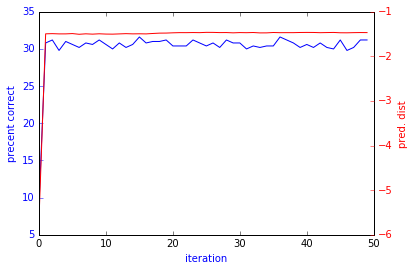

In [51]:
# fig = plt.figure(figsize=(10,10))
# fig, ax = plt.subplots()
# ax.plot(ELBO)
# ax.set_xlabel('iteration', color='b')
# ax.set_ylabel('ELBO', color='b')
# ax.tick_params('y', colors='b')

fig, ax = plt.subplots()
ax.plot(prc_correct)
ax.set_xlabel('iteration', color='b')
ax.set_ylabel('precent correct', color='b')
ax.tick_params('y', colors='b')


ax2 = ax.twinx()
ax2.plot(ln_PD, 'r')
ax2.set_ylabel('pred. dist', color='r')
ax2.tick_params('y', colors='r')


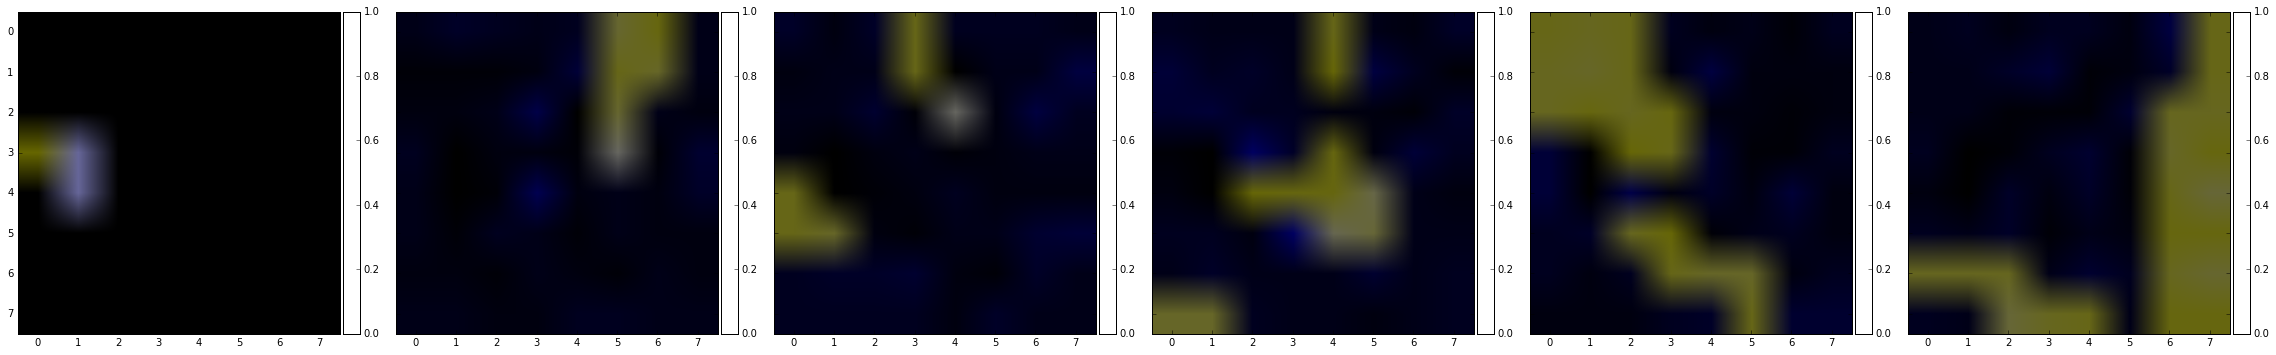

In [52]:

see_posterior_overlay(best_Q_Z, test_object_map[0])

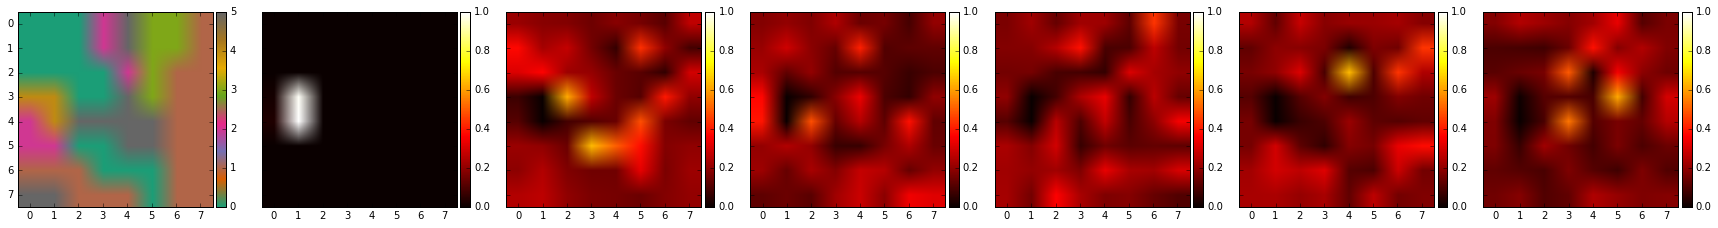

In [53]:

see_Q_Z(best_Q_Z.reshape((K,sqrt_D,sqrt_D)), target_object_map = test_object_map_image)


In [54]:
print best_theta
print p_on, p_off

[ 0.70791668  0.04252451]
0.76 0.1


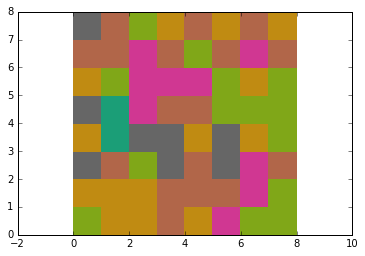

In [55]:
_=see_Z_sample(Z[-1], sqrt_D)

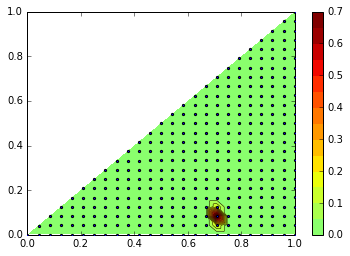

In [56]:
see_Q_theta(Q_theta, lkhd_param_grid)